<a href="https://colab.research.google.com/github/MiguelUrenaPliego/GeoimageVision/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Only execute this cell if you are using google colab
!pip install geopandas
!pip install folium matplotlib mapclassify
!pip install lightning
!pip install git+https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git
!pip install git+https://github.com/Rusteam/segmentation_models.pytorch.git@sam
!pip install kornia[x]
# After this restart the session

  Cloning https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git to /tmp/pip-req-build-_f8au_ad
  Running command git clone --filter=blob:none --quiet https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git /tmp/pip-req-build-_f8au_ad
  Resolved https://github.com/GeomaticsCaminosUPM/GeoVisionDataset.git to commit 5d27cb026fe454904843fedebd0824c8240b41d7
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/Rusteam/segmentation_models.pytorch.git (to revision sam) to /tmp/pip-req-build-bi0x97ns
  Running command git clone --filter=blob:none --quiet https://github.com/Rusteam/segmentation_models.pytorch.git /tmp/pip-req-build-bi0x97ns
  Running command git checkout -b sam --track origin/sam
  Switched to a new branch 'sam'
  Branch 'sam' set up to track remote branch 'sam' from 'origin'.
  Resolved https://github.com/Rusteam/segmentation_models.pytorch.git to commit f1ac494fb51714975eecdc78a2d785ab202cdaf7
  Installing build dependencies ... done
  Getting requi

In [ ]:
#!rm -r GeoVisionModels
!git clone https://github.com/GeomaticsCaminosUPM/GeoVisionModels.git

Cloning into 'GeoVisionModels'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 90 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 3.04 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
import GeoVisionModels.code.seg_utils as utils
import GeoVisionModels.code.seg_losses as losses
import GeoVisionModels.code.SemanticSegmentation as Seg

from GeoVisionDataset import GeoDataset, Grid, ImageData, SegmentationData
from GeoVisionDataset.grid import ipyleaflet_drawable_map
import GeoVisionDataset.wms
import GeoVisionDataset.osm

import lightning.pytorch as pl
import torch, torchmetrics
import numpy as np
import geopandas as gpd
import shapely
import os
import segmentation_models_pytorch as smp
from GeoVisionModels.code.seg_utils import SegmentationTransforms

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
encoder="sam-vit_b"
weights = "sa-1b" # input size must be 1024 for weights sa-1b
input_size = (1024, 1024) # input size must be square
batch_size = 2
augment_rate = 4
num_workers = 1
background_index = 0

max_epochs = 3

mean=[0.44368124, 0.4537536, 0.45856014]
std=[0.1987232, 0.17570017, 0.15577587]

transforms = SegmentationTransforms.Compose([
    SegmentationTransforms.Resize(input_size),
    utils.aug_transforms_2,
    SegmentationTransforms.toTensor(),
    SegmentationTransforms.Normalize(mean,std),
    SegmentationTransforms.toTensor()
])

transforms_val = SegmentationTransforms.Compose([
    SegmentationTransforms.Resize(input_size),
    SegmentationTransforms.toTensor(),
    SegmentationTransforms.Normalize(mean,std),
    SegmentationTransforms.toTensor()
])

labels = {
    0 : {'class' : 'building', 'rgb' : [255,255,255]},
    1 : {'class' : 'unlabeled', 'rgb' : [0,0,0]},
}

rgb_to_labels = {
    '255255255' : 0,
    '000000000' : 1
}


gamma = 0.75

model_log_folder = 'model'

In [ ]:
bbox = [-3.70,40.361,-3.69,40.364]
dataset_bounds = gpd.GeoSeries(shapely.box(*bbox),crs=4326)

In [ ]:
img_resolution = (0.5, 0.5)  # 50 cm per pixel (width, height)
img_shape = (1024, 1024)  # Image shape in pixels (width, height)
tile_overlap = 0.2  # 20% overlap on each side of the grid tiles
tile_in_dataset = 0  # 0% of the tile has to be inside the dataset bounds

In [ ]:
grid = Grid(
    dataset_bounds=dataset_bounds,  # Define the dataset bounds
    resolution=img_resolution,      # Define the image resolution (meters per pixel)
    shape=img_shape,                # Define the image shape (pixels)
    overlap=tile_overlap,                # Set the overlap between tiles
    tile_in_dataset=tile_in_dataset # Set the minimum tile coverage within bounds
)

In [ ]:
img_url = 'Google Satellite'

In [ ]:
img_obj = GeoVisionDataset.image.XYZ(img_url,dataset_bounds)

Maximum available zoom level is 22 for a max resolution of 0.03832276771737122 m per pixel


In [ ]:
overpass_query = """
[out:json];
(
  way["building"]( {{bbox}} );
  relation["building"]( {{bbox}} );
);
(._; >;);
out geom;
"""

In [ ]:
basemap = GeoVisionDataset.wms.xyz_folium_basemap(img_url)

response = GeoVisionDataset.osm.overpass_api_query(overpass_query,bounds=dataset_bounds)
m = response.geometry.explore()
m = dataset_bounds.boundary.explore(m=m,color='red')
basemap.add_to(m)
m

In [ ]:
seg_obj = GeoVisionDataset.segmentation.OSMPolygon(overpass_query=overpass_query,semantic_class=1)

In [ ]:
ds = GeoDataset(
    grid=grid,
    image=img_obj,
    segmentation=seg_obj,
    n_classes=1,
    instances=False #Our dataset is only semantic
)

In [ ]:
ds.to_map(mode='grid')

In [ ]:
ds.to_map([0,1,2],mode='all')

/usr/local/lib/python3.11/dist-packages/GeoVisionDataset/geodataset.py:369: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  m=geometry[geometry['semantic_class'] == 0].explore(m=m,color='black',legend=False)


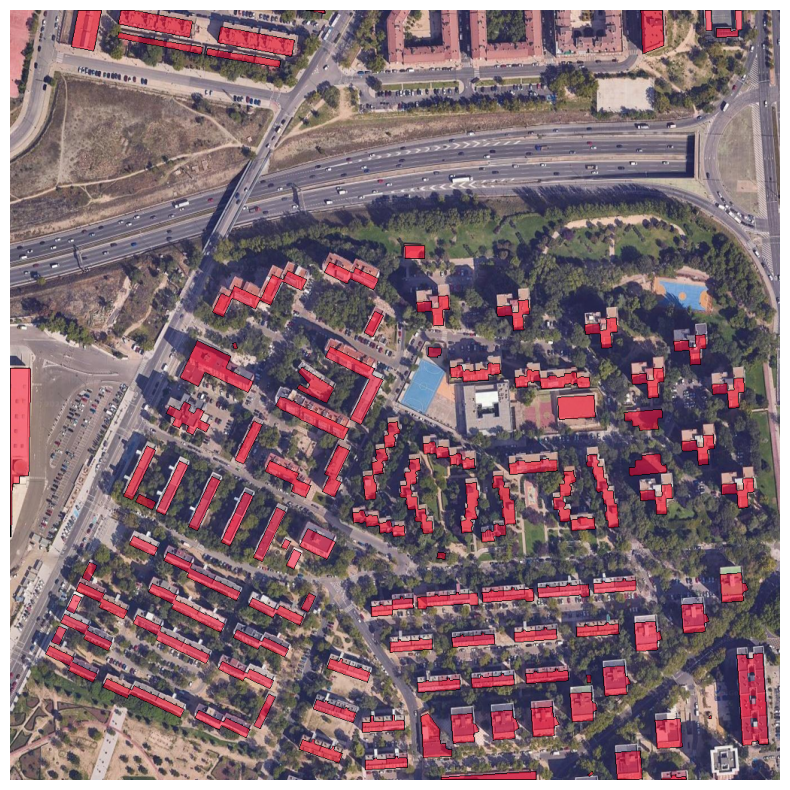

In [ ]:
ds.plot(0,ann_mode='coco')

In [ ]:
ds.select_all_tiles()

In [ ]:
ds.download(img_path='dataset/images',anns_path='dataset/anns',ann_mode='raster',allow_empty_anns=False)

Creating image download path dataset/images
Creating annotations download path dataset/anns
Creating annotations download path dataset/anns/semantic
Progress: [] 100% (3/3)Grid tiles saved as dataset/images/grid_tiles.geojson
Grid bounds saved as dataset/images/grid_bounds.geojson
Dataset bounds saved as dataset/images/dataset_bounds.geojson
Grid tiles saved as dataset/anns/grid_tiles.geojson
Grid bounds saved as dataset/anns/grid_bounds.geojson
Dataset bounds saved as dataset/anns/dataset_bounds.geojson
osm overpass query saved as dataset/anns/anns_metadata_0_overpass_query.txt


In [ ]:
dm = Seg.get_train_datamodule(
    labels=labels,
    rgb_to_labels=rgb_to_labels,
    num_classes=2,
    ignore_index=None,
    img_dir="dataset/images",
    mask_dir="dataset/anns/semantic",
    find_criteria = {"tile":True,".jpg":True,".aux":False},
    img_to_mask = {".jpg":"_semantic.png"},
    train_folders="",
    val_folders="",
    img_folder="",
    mask_folder=""
)

dm.preprocess(
    batch_size=batch_size,
    augment_rate=augment_rate,
    train_transforms=transforms,
    val_transforms=transforms_val,
    num_workers=num_workers,
    min_num_classes=2,
    min_area=0.001,
    balanced_inds=True
)

Warning. No test paths given and test_perc = 0 so test will be the same a validation
0 empty masks deleted


In [ ]:
test_dm = Seg.get_test_datamodule(
    labels=labels,
    num_classes=2,
    rgb_to_labels=rgb_to_labels,
    ignore_index=None,
    img_dir="dataset/images",
    test_folders="",
    img_folder="",
    find_criteria = {"tile":True,".jpg":True,".aux":False}
)

test_dm.preprocess(
    batch_size=1,
    augment_rate=1,
    test_transforms=transforms_val,
    num_workers=num_workers
  )

Datamodule only for testing model


In [ ]:
class_weights = np.array(utils.get_class_weights(dm,balanced=True,method='area',normalize = True))
class_weights = np.power(class_weights, gamma)
class_weights = list(class_weights * len(class_weights) / np.sum(class_weights))
class_weights

[np.float64(0.34340090869006795), np.float64(1.6565990913099322)]

In [ ]:
loss = losses.AsymmetricUnifiedFocalLoss(mu=0.5,delta=0.7, gamma=gamma, common_class_index=background_index,class_weights=class_weights)
accuracy = torchmetrics.JaccardIndex(task="multiclass", num_classes=dm.num_classes)

In [ ]:
# ulabeled, building
clean_mask_area = np.array([2,20]) # min area m^2
clean_mask_len =  np.array([0,4]) # min width m

clean_mask_area = clean_mask_area / (max(img_resolution)**2) # img resolution
clean_mask_len = clean_mask_len / (2 * max(img_resolution)) # 0.5 width and img resolution

def clean_mask_func(mask):
    return utils.clean_mask_by_area(mask,clean_mask_area,clean_mask_len,background_index=background_index,open_first=True,footprint="octagon")


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision('medium')
device

'cuda'

In [ ]:
def unetSAM(num_classes,input_size, encoder,weights=None,freeze_encoder=True):
    import segmentation_models_pytorch as smp
    from segmentation_models_pytorch.encoders import get_encoder
    if weights == None:
        if freeze_encoder:
            import warnings
            warnings.warn("Setting freeze_encoder to False as no weights were given")
            freeze_encoder = False
    _encoder = get_encoder(encoder, weights=weights, img_size=input_size[0], depth=4,in_channels=3)
    model=smp.create_model("unetplusplus", encoder,encoder_weights=weights, encoder_depth=4, decoder_channels=[256, 128, 64, 32],in_channels=3,classes=num_classes)
    model.encoder = _encoder
    if freeze_encoder:
        utils.set_parameter_requires_grad(model.encoder,False)
    return model

model_arch = unetSAM(dm.num_classes,input_size, encoder,weights,True)
model = Seg.Model(dm.num_classes,model=model_arch,loss = loss, learning_rate=0.0001,
                  accuracy=accuracy,device=device)

utils.count_parameters(model)

/usr/local/lib/python3.11/dist-packages/segmentation_models_pytorch/encoders/sam.py:121: UserWarning: Only 153 out of pretrained 177 SAM image encoder modules are loaded. Missing modules: []. Unused modules: ['blocks.0.attn.rel_pos_h', 'blocks.0.attn.rel_pos_w', 'blocks.1.attn.rel_pos_h', 'blocks.1.attn.rel_pos_w', 'blocks.2.attn.rel_pos_h', 'blocks.2.attn.rel_pos_w', 'blocks.3.attn.rel_pos_h', 'blocks.3.attn.rel_pos_w', 'blocks.4.attn.rel_pos_h', 'blocks.4.attn.rel_pos_w', 'blocks.5.attn.rel_pos_h', 'blocks.5.attn.rel_pos_w', 'blocks.6.attn.rel_pos_h', 'blocks.6.attn.rel_pos_w', 'blocks.7.attn.rel_pos_h', 'blocks.7.attn.rel_pos_w', 'blocks.8.attn.rel_pos_h', 'blocks.8.attn.rel_pos_w', 'blocks.9.attn.rel_pos_h', 'blocks.9.attn.rel_pos_w', 'blocks.10.attn.rel_pos_h', 'blocks.10.attn.rel_pos_w', 'blocks.11.attn.rel_pos_h', 'blocks.11.attn.rel_pos_w'].
  warnings.warn(


Model trainable params 2491330, total params 92450690


(2491330, 92450690)

In [ ]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else num_workers,
    default_root_dir=model_log_folder,
    enable_checkpointing=True
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                       | Params | Mode 
----------------------------------------------------------------
0 | accuracy | MulticlassJaccardIndex     | 0      | train
1 | loss     | AsymmetricUnifiedFocalLoss | 0      | train
2 | model    | UnetPlusPlus               | 92.5 M | train
----------------------------------------------------------------
2.5 M     Trainable params
90.0 M    Non-trainable params
92.5 M    Total params
369.803   Total estimated model params size (MB)
254       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type                       | Params | Mode 
----------------------------------------------------------------
0 | accuracy | MulticlassJaccardIndex     | 0      | train
1 | loss     | AsymmetricUnifiedFocalLoss | 0      | train
2 | model    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
trainer.test(model, datamodule=dm)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.43600237369537354    │
│         test_loss         │    0.3864406943321228     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.43600237369537354, 'test_loss': 0.3864406943321228}]

In [ ]:
max_version = -1
max_version_folder = None

for folder in os.listdir(model_log_folder+"/lightning_logs"):
    version_number = Seg.get_version_number(folder)
    if version_number > max_version:
        max_version = version_number
        max_version_folder = folder

checkpoint_folder = os.path.normpath(model_log_folder + "/lightning_logs/" + max_version_folder)
checkpoint_folder

'model/lightning_logs/version_2'

In [ ]:
i = 0

n = 0
for x in iter(test_dm.test_dataloader()):
    if n == i:
      if type(x) is list and len(x) == 2:
          x = x[0]

      pred = model.predict(x,get_prob=False)
      for j in pred:
        y = clean_mask_func(j)

      break
    else:
      n += 1

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

plt.imshow(x[0].permute(1,2,0)*torch.tensor(std)+torch.tensor(mean))

# Normalize y to a colormap
cmap = plt.cm.viridis  # or any other colormap
colors = cmap(y / y.max())  # shape: (10, 10, 4), includes alpha channel

# Modify the alpha channel based on your condition
colors[..., 3] = np.where(y == 0, 0.0, 0.5)  # set alpha: 0 for y==0, 0.5 otherwise

plt.imshow(colors)

In [ ]:
test_out_folder = checkpoint_folder + "/model_test/" + folder
Seg.geoimage_test(test_out_folder,test_dm,model,clean_mask_func,overlap=tile_overlap)

output folder model/lightning_logs/version_2/model_test/version_2 created


/content/GeoVisionModels/code/SemanticSegmentation.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  x_pixel_size = (bounds[2] - bounds[0]) / x_shape
/content/GeoVisionModels/code/SemanticSegmentation.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  y_pixel_size = (bounds[3] - bounds[1]) / y_shape
/usr/local/lib/python3.11/dist-packages/rasterio/transform.py:190: RuntimeWarning: divide by zero encountered in scalar divide
  (east - west) / width, (south - north) / height)
/usr/local/lib/python3.11/dist-packages/affine/__init__.py:502: RuntimeWarning: invalid value encountered in scalar multiply
  sa * ob + sb * oe,
/usr/local/lib/python3.11/dist-packages/affine/__init__.py:504: RuntimeWarning: invalid value encountered in scalar multiply
  sd * oa + se * od,


CPLE_AppDefinedError: Attempt to create 0x0 dataset is illegal,sizes must be larger than zero.